In [ ]:
!pip install tensorflow==1.4.0

ERROR: Could not find a version that satisfies the requirement tensorflow==1.4.0 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==1.4.0


In [1]:
from keras.optimizers import Optimizer
from keras import backend as K
import tensorflow.compat.v1 as tf
class PSO():
    def __init__(self, 
                 TF2_model, 
                 update_w = 1E-5,
                 update_c1 = .1,
                 update_c2 = 1,
                 population_size = 10):
        self.nnmodel = TF2_model
        self.population_size = population_size
        self.population = self._createPopulation()
        self.update_w = update_w
        self.update_c1 = update_c1
        self.update_c2 = update_c2
        self.pbest = {'fitness':tf.zeros([population_size]), 
                      'weights':tf.zeros(self.population['weights'].shape)}
        self.force_evaluate = True
    pass 

    def _createPopulation(self):
        self.population = {}
        # creating the weights
        weights = self._flattenWeightsTFKeras()
        self.population['weights'] = tf.stack([tf.random.normal(weights.shape, stddev=.05) for i in range(self.population_size)], axis=0)
        self.population['velocity'] = tf.stack([tf.random.normal(weights.shape, stddev=.0) for i in range(self.population_size)], axis=0)
        # self.population['graphs'] = [tf.keras.models.clone_model(self.nnmodel) for i in range(self.population_size)]
        return self.population
    pass 

    def _flattenWeightsTFKeras(self):
        flated_weights = tf.Variable(tf.concat([tf.reshape(weights, [-1]) for weights in self.nnmodel.trainable_weights], axis=-1))
        return flated_weights
    pass 

    def _recoverFlattenWeightsTFKeras(self, model, flated_weights):
        access_index = 0
        for model_tesnsor in model.trainable_weights:
            element_shape = model_tesnsor.shape.as_list()
            element_number = np.ones(element_shape).sum().astype('int')
            model_tesnsor.assign(tf.reshape(flated_weights[access_index:access_index + element_number], element_shape))
            access_index += element_number
        pass
        return model
    pass 

    def update_fitness(self, fitness_function):
        fitness_rec = []
        for ind_index in range(self.population_size):
            self._recoverFlattenWeightsTFKeras(self.nnmodel, self.population['weights'][ind_index])
            fitness_rec.append(fitness_function())
        pass 
        return tf.concat(fitness_rec, axis=0)
    pass 

    def minimize(self, fitness_function):
        #print('PSO')
        # get fitnesses of each individual
        fitness_rec = self.update_fitness(fitness_function)
        # print(fitness_rec)
        #print('inside PSO optimization')

        # take change to jump out of the outlier
        if self.force_evaluate:
            self.force_evaluate = False
            self.pbest['fitness'] = tf.identity(fitness_rec)
            self.pbest['weights'] = tf.identity(self.population['weights'])
        else :
            self.pbest['fitness'] = tf.identity(fitness_rec + self.pbest['fitness'])/2 
        pass 
        
        # update pbest memory
        rec_cmp = tf.cast(tf.math.less(self.pbest['fitness'], fitness_rec), dtype=tf.float32)
        self.pbest['fitness'] = tf.identity(self.pbest['fitness'] * rec_cmp + fitness_rec * (-1 * rec_cmp + 1)) # update the pbest fitness
        rec_cmp = tf.reshape(rec_cmp, [-1, 1])
        # print(rec_cmp)
        self.pbest['weights'] = tf.identity(self.pbest['weights'] * rec_cmp + self.population['weights'] * (-1 * rec_cmp + 1)) # update the pbest weights
        
        # create gbest tensors
        # gbest = tf.identity(self.population['weights'][tf.argmin(fitness_rec)])
        gbest = tf.identity(self.pbest['weights'][tf.argmin(self.pbest['fitness'])])

        # update population 
        # vid+1 = w∙vid+c1∙rand()∙(pid-xid)+c2∙Rand()∙(pgd-xid) 
        # xid+1 = xid+vid
        self.population['velocity'] = tf.identity(
                                      self.update_w * tf.identity(self.population['velocity']) +\
                                    #   self.update_c1 * tf.math.abs(tf.random.normal(self.population['velocity'].shape, stddev=.05, dtype=tf.float32)) * tf.identity(self.pbest['weights'] - self.population['weights']) +\
                                    #   self.update_c2 * tf.math.abs(tf.random.normal(self.population['velocity'].shape, stddev=.05, dtype=tf.float32)) * tf.identity(gbest - self.population['weights'])
                                      self.update_c1 * tf.math.abs(tf.random.normal([self.population_size, 1], stddev=1E-4, dtype=tf.float32)) * tf.identity(self.pbest['weights'] - self.population['weights']) +\
                                      self.update_c2 * tf.math.abs(tf.random.normal([self.population_size, 1], stddev=1E-4, dtype=tf.float32)) * tf.identity(gbest - self.population['weights'])
                                      
                                      )
        self.population['weights'] = tf.identity(self.population['velocity'] + self.population['weights'])

        return self.pbest['fitness'][tf.argmin(self.pbest['fitness'])]
    pass 

    def getTopModel(self, fitness_function):
        # get fitnesses of each individual
        fitness_rec = self.update_fitness(fitness_function)

        # create gbest tensors
        selected_ind = self.pbest['weights'][tf.argmax(fitness_rec)] 

        #set the wieghts to discriminator
        self._recoverFlattenWeightsTFKeras(self.nnmodel, selected_ind)
        return self.nnmodel
    pass

pass 

In [2]:
import datetime
import os
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
IMAGE_SIZE = 64
INPUT_DATA_DIR = "/content/drive/MyDrive/Data/COVID/COVID/data-covid/Covid/" # Path to the folder with input images. For more info check simspons_dataset.txt
OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


# In[ ]:
# In[ ]:


# Training
input_images = np.asarray([np.asarray(Image.open(file).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))



Input: (500, 64, 64, 3)


In [3]:
noise_dim = 100
image_shape = (64,64,3)
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dense, BatchNormalization, LeakyReLU, Input,Reshape, MaxPooling2D, Flatten, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam


def build_G():
    
    model = Sequential()
    model.add(Dense(2048,input_dim = noise_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(8 * 8 * 256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))
    return model
G = build_G()
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         8

In [4]:
from keras.optimizers import Optimizer
from keras import backend as K
def build_D():
    Input = tf.keras.Input([64,64,3])
    nInput = Input/128 - 1
    conv1 = tf.keras.layers.Conv2D(64, [5, 5], strides=(2, 2), padding="valid", activation=tf.nn.relu)(nInput) #[14,14]
    conv2 = tf.keras.layers.Conv2D(128, [3, 3], strides=(2, 2), padding="valid", activation=tf.nn.relu)(conv1) #[7,7]
    conv3 = tf.keras.layers.Conv2D(256, [3, 3], strides=(2, 2), padding="valid", activation=tf.nn.relu)(conv2) #[4,4]
    fc = tf.keras.layers.Flatten()(conv3)
    fc1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)(fc)
    fc2 = tf.keras.layers.Dense(512, activation=tf.nn.relu)(fc1)
    fc3 = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(fc2)
    out = tf.keras.layers.Dense(10, activation=None)(fc3)
    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=5, padding='valid',input_shape = image_shape))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(AveragePooling2D(pool_size=2))
    # model.add(Conv2D(128, kernel_size=3, padding='valid'))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(AveragePooling2D(pool_size=2))
    # model.add(Conv2D(256, kernel_size=3, padding='valid'))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(AveragePooling2D(pool_size=2))
    # model.add(Flatten())
    # model.add(Dense(1024))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(Dense(1, activation='sigmoid'))
    # model.compile(loss='binary_crossentropy',
    #           optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    # print(model)
    return tf.keras.Model(inputs=Input, outputs=out)
D = build_D()
D.compile(loss='binary_crossentropy')
D.summary()
opt = PSO(D)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0     

In [6]:
def build_gan():
  
    D.trainable = False
    gan_input = Input(shape=(noise_dim,))
    gan_out = D(G(gan_input))
    gan = Model(gan_input,gan_out)
    gan.compile(loss='mean_squared_error', optimizer = 'adam')
    return gan
GAN = build_gan()
GAN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         35282435  
_________________________________________________________________
model (Functional)           (None, 10)                3400586   
Total params: 38,683,021
Trainable params: 35,249,411
Non-trainable params: 3,433,610
_________________________________________________________________


In [7]:
def sample_noise(batch_size):
    return np.random.normal(size=(batch_size, noise_dim))

def smooth_pos_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_neg_labels(y):
    return y + np.random.random(y.shape) * 0.3

In [ ]:
def load_batch(data, batch_size,index):
    return data[index*batch_size: (index+1)*batch_size]

0 [D loss: 0.200260] [G loss: 0.940644]
1 [D loss: 0.200228] [G loss: 0.921085]
2 [D loss: 0.200284] [G loss: 0.915689]
3 [D loss: 0.200249] [G loss: 0.905445]
4 [D loss: 0.200258] [G loss: 0.903229]
5 [D loss: 0.200279] [G loss: 0.920009]
6 [D loss: 0.200287] [G loss: 0.906306]
7 [D loss: 0.200284] [G loss: 0.907817]
8 [D loss: 0.200293] [G loss: 0.916399]
9 [D loss: 0.200263] [G loss: 0.918891]


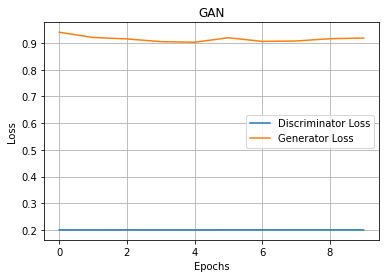

In [8]:
discriminator_loss = 0
generator_loss = 0
index = 0
batch_size = 64  
n_batches = int(input_images.shape[0] / batch_size)
d_loss_logs = []
g_loss_logs = []
save_interval = 200
size = len(input_images)
def save_imgs(epoch):
  r, c = 5, 5
  noise = sample_noise(size)
  gen_imgs = G.predict(noise)
  # Rescale images 0 - 1
  gen_imgs = (1/2.5) * gen_imgs + 0.5
  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :,:,:])
      axs[i,j].axis('off')
      cnt += 1
      fig.savefig("/content/drive/MyDrive/output/%d.png" % epoch)
      plt.close()
def dloss():
   x = input_images
   noise = sample_noise(size)
   generated_images = G.predict(noise)
   y_real = np.ones(size)
   y_real = smooth_pos_labels(y_real)
   y_fake = np.zeros(size)
   y_fake = smooth_neg_labels(y_fake)
   d_loss_real = tf.reduce_mean(tf.keras.losses.mean_squared_error(tf.one_hot(y_real, 10, axis=-1), D(x)))
   d_loss_fake =  tf.reduce_mean(tf.keras.losses.mean_squared_error(tf.one_hot(y_fake, 10, axis=-1), D(generated_images)))
   #print(d_loss_real)
   d_loss = d_loss_real + d_loss_fake
   d_loss = tf.convert_to_tensor(d_loss)
   return d_loss

def train(epochs=10, batch_size=64, save_interval=1):
    for i in range(epochs):
      discriminator_loss = opt.minimize(dloss)
      #print('dis_loss')
      #print(discriminator_loss)
      #print('1st epoch')
      noise = sample_noise(size)
      y_real = np.ones(size)
      y_real = smooth_pos_labels(y_real)
      generator_loss = GAN.train_on_batch(noise, y_real)
      dis_loss = tf.dtypes.cast(discriminator_loss, tf.float32)
      print ("%d [D loss: %f] [G loss: %f]" % (i, dis_loss , generator_loss))
      d_loss_logs.append([i, dis_loss])
      g_loss_logs.append([i, generator_loss])
      if i % save_interval == 0:
        save_imgs(i)


    d_loss_logs_a = np.array(d_loss_logs)
    g_loss_logs_a = np.array(g_loss_logs)

        # At the end of training plot the losses vs epochs
    plt.plot(d_loss_logs_a[:,0], d_loss_logs_a[:,1], label="Discriminator Loss")
    plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN')
    plt.grid(True)
    plt.show() 
save_interval = 200
train(10,64,200)
GAN.save('gan.h5')